# How To Cut
## Utility-scale QAOA

So to date, I have developed Quantum Circuits to purely measure Entanglement in both a two-qubit bell state, and a 100-qubit GHZ state. It's time to actually solve a problem, specifically the Max-Cut optimisation problem. To do this we are going to be using our first Quantum Algorithm, QAOA. So as before, we are following along with a wonderful IBM tutorial, however, unlike IBM, we will be diving head first into some of the underlying theory and code in more detail. Really so we can start to build up a stronger foundation of knowledge rather than blindingly following the tutorial. So let's get into it. Beginning with some theory. 

[IBM Tutorial](https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-approximate-optimization-algorithm)

### The Max Cut Problem
A rather innocent looking problem, the aim is to take a graph (e.g. a few nodes with edges/lines between them) and colour the nodes into one of two colours. If a edge (line) is then between two nodes of different colours, it is treated as cut. If the edge is between nodes of the same colour it is not. So it's not really cutting in the conventional sense. 

So let's take the graph below with 5 nodes & 6 edges. 

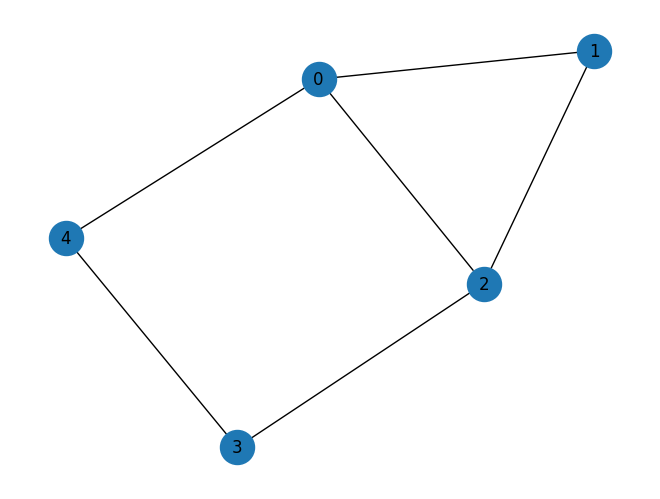

In [1]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

Now let's look at a graph, with three nodes marked as red, leading to two cuts. E.g. two lines that are connected by nodes with different colours.

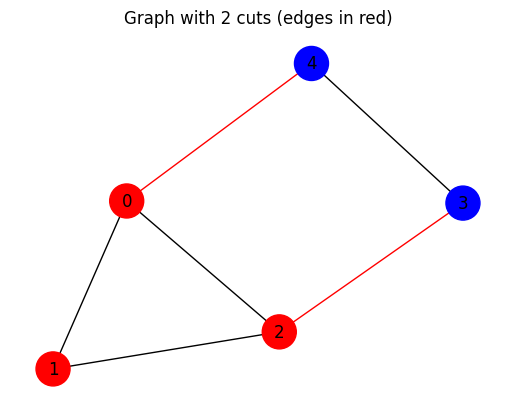

In [2]:
# Second graph with 2 cuts (partition: {0,1,2} vs {3,4})
color_map = ["red", "red", "red", "blue", "blue"]
cut_edges = [(2, 3), (0, 4)]  # These edges are "cut" between partitions

fig, ax = plt.subplots()
draw_graph(
    graph,
    node_size=600,
    with_labels=True,
    ax=ax,
    node_color=color_map,
    edge_color=["red" if (u, v) in cut_edges or (v, u) in cut_edges else "black" for u, v in graph.edge_list()]
)
plt.title("Graph with 2 cuts (edges in red)")
plt.show()

The aim of the max cut is to maximise the number of cuts. 

This is known as a NP-hard problem, an NP hard problem being one that has no known polynomial-time algorithm. A polynomial-time algorithm being one where time grows at most a polynomial function of the size of the input. 

Since, for Max Cut there is a \(\text{Number of nontrivial cuts} = 2^{n-1} - 1\) (this is exponential)

A real world utilities application includes:

#### Power Grid Optimisation

Let's say you are a system operator, and you need the ability to split your network into two smaller zones to allow manageable isolation of faults. So a fault in Zone A can be isolated so Zone B remains live.

Therefore, Max-Cut allows you to pinpoint the exact transmission lines to sectionalize so a fault in one segment won’t cascade across the entire grid. By maximizing the sum of high-capacity inter-zone lines, you create clear boundary points where breakers or switches can isolate a disturbance in seconds. 

In the event of a substation failure or line overload, operators open those boundary devices to confine the fault and prevent overloads on adjacent lines. Meanwhile, the unaffected segment stays energized, ensuring that critical loads like hospitals, data centers, and emergency services remain online. This targeted approach to resilience lets utilities reinforce or automate those key links for faster fault restoration and fewer widespread outages.

#### Load Balancing in Energy Distribution

During peak demand periods, some regions face overload risks while others run below capacity. Modeling the grid as a weighted graph and applying Max-Cut reveals the partition with the greatest transmission capacity between zones. Operators can then reroute power along these high capacity inter-zone ties (that are cut), shifting surplus energy from low-demand areas into high-demand regions without overstressing local infrastructure. By leaning on the strongest connections, the grid balances loads more evenly, reducing the likelihood of line sag, transformer overheating, and voltage instability. The result is a dynamically adaptive network that maintains reliable service even as consumption patterns swing wildly.

#### Maintenance Scheduling

Routine maintenance often requires de-energizing parts of the grid, which risks downtime and customer inconvenience. A Max-Cut-based partition shows exactly which breakers to open to isolate one segment while keeping the rest of the network live. Crews can safely work on lines, transformers, or switchgear within the offline zone without impacting other areas. Because the cut maximizes boundary capacity, any unintended load shifts are absorbed by the still-energized segment’s infrastructure. This surgical isolation minimizes planned outages, enhances technician safety, and keeps power flowing for the majority of users.

### The QAOA 

Quantum Approximate Optimization Algorithm is a hybrid quantum-classical algorithm that allows you to find approximate solutions, where you:
1. Encode the problem into a quantum system
2. Apply a series of quantum operations
3. Measure the outcome
4. Use a classical optimiser to tune free parameters (2p variational angles), and re-run. The objective is to explore the parameter landscape. 

## Step 1: Mapping the Problem

To solve the classical problem with Quantum Computing, we need to begin by turning it into quantum circuits and operators. Doing this requires us to do three things:

### A. Turn the graph problem into an optimisation problem (through mathematical reformulations) using QUBO notation:

So let's think about what the classical problem might look like, so we know the aim of the game is finding the minimal of a function f (x)

$$
\min_{x \in \{0,1\}^n} f(x)
$$

We also know that for a given edge, if either the nodes are different from the other e.g. one is 0, and the is 1. Then the edge is cut. This can be expressed as:

$$
\max_{x \in \{0,1\}^n} \sum_{i,j} (x_i + x_j - 2 x_i x_j)
$$

this maximisation can be then rewritten as the minimisation

$$
\min{x \in \{0,1\}^n} \sum_{i,j} (2 x_i x_j - x_i - x_j)
$$

The MaxCut problem can be expressed in the following QUBO notation:

$$
\max_{x \in \{0,1\}^n} x^T Q x
$$

where Q is a n x n matrix of real numbers, The dimension n matches the number of nodes in your graph, x is the vector of binary variables, and XT indicates the transpose of the vector x. 

Don't get too bogged down in the maths for now, I spent an hour trying to figure it out and failed.

####  What is QUBO notation?
S

### B. Turn the optimisation problem into a Hamiltonian

**Callout**
What is a Hamiltonian?

In quantum mechanics, its an operator that represents the total energy if the system. In the context of Max-Cut, we construct a Hamiltonian where the lowest energy state (ground state) corresponds to the optimal solution of the problem. Problems that can be encoded into Hamiltonians are often those with discrete variables such as Max Cut where each vertex is a qubit, which can be 0 or 1. 



$$
H_C \;=\; \sum_{i<j} Q_{ij}\, Z_i Z_j \;+\; \sum_i b_i\, Z_i
$$

This resulting cost function Hamiltonian, has a ground state that corresponds to a minimal cost function. In other words, the energy is minimised when the connected vertices are in opposite sets (leading to a maximum cut). Now each Vertex will be associated with a qubit in state ∣0⟩ or ∣1⟩. So we can associate the Z operator with each qubit:

Z∣0⟩=∣0⟩   Z∣1⟩=−∣1⟩

**Callout**
What is the Z operator?

Pauli-Z operator, one of the three Pauli matrices used to manipulate qubits. The Pauli-Z gate is a phase-flip gate: it changes the phase of ∣1⟩ but not ∣0⟩.

Therefore, we know when an edge ($v_1, v_2$) belongs to the cut if the eigenvalue of 
$$
\left( Z_1 \lvert v_1 \rangle \right) \cdot \left( Z_2 \lvert v_2 \rangle \right) = -1
$$


Addiitonally, in this case, we are treating all vertexes as symmetric. We don't care if its 0 or 1. Therefore, we can set the bias term bi = 0 since there is no preference. Leading to:

$$
H_C \;=\; \sum_{i<j} Q_{ij}\, Z_i Z_j \
$$

In this case, we are also making it unweighted, $ Q_{ij} = 1 $ e.g. the edges are either present or not, they are not weighted. In a weighted graph, you would make some edges more valuable to cut than others.

$$
H_C \;=\; \sum_{i<j} Z_i Z_j \
$$

Finally! We have a hamiltonian to define:

In [3]:
import rustworkx as rx

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    "Input: graph (an object with nodes and edges). Output: list of Pauli terms for Max-Cut Hamiltonian."
    pauli_list = [] # To hold the Pauli terms
    for edge in list(graph.edge_list()): # Iterate over each edge in the graph
        weight = graph.get_edge_data(edge[0], edge[1]) # Get the weight of the edge
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight)) # Append the Pauli term for this edge
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
print("Max-Cut Pauli List:", max_cut_paulis)

Max-Cut Pauli List: [('ZZ', [0, 1], 1.0), ('ZZ', [0, 2], 1.0), ('ZZ', [0, 4], 1.0), ('ZZ', [1, 2], 1.0), ('ZZ', [2, 3], 1.0), ('ZZ', [3, 4], 1.0)]


Notice that all have an equal weight! With the brackets denoting the edge, and the corresponding edge.

A Pauli List is a way to represent a quantum operator as a sum of Pauli terms. Each item in the list specifies:

The type of Pauli operator (e.g., "Z", "ZZ", "X", etc.)
The qubits it acts on (e.g., [0, 1])
The coefficient (weight) for that term

[("ZZ", [0, 1], 1.0)] means $ 1.0 \cdot Z_0 Z_1 $


In [4]:
from qiskit.quantum_info import SparsePauliOp
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
# Convert the Pauli list to a SparsePauliOp. Using n, it pads with I's for qubits not ZZ-ed.
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### C. Create the quantum circuit

We now have the Hamilonian $H_C$ contains the quantum definition of your problem. To do this we will build a quantum circuit that executes the cost hamiltonian using QAOA. 

QAOA begins by initializing all qubits in the ∣0⟩ state, then applies a Hadamard gate to each qubit.
This creates a uniform superposition over all possible states, which serves as the starting point for the algorithm

Then we we apply alternating layers of the cost Hamiltonian and a mixing Hamiltonian, 

This is done by applying the cost hamiltonian operator
$$
\exp\left\{ -i \gamma_k H_C \right\}
$$
and the mixer hamiltonian layer
$$
\exp\left\{ -i \beta_k H_m \right\}
$$
with angles $\gamma_1, \ldots, \gamma_p$ and $\beta_1, \ldots, \beta_p$.






The quantum circuit that you generate is parametrized by 
$γ_i$ and $β_i$, so you can try out different values of $γ_i$ and β_i and sample from the resulting state.

Therefore, we can use classical optimization to find the best parameters that minimize (or maximize) the cost function.


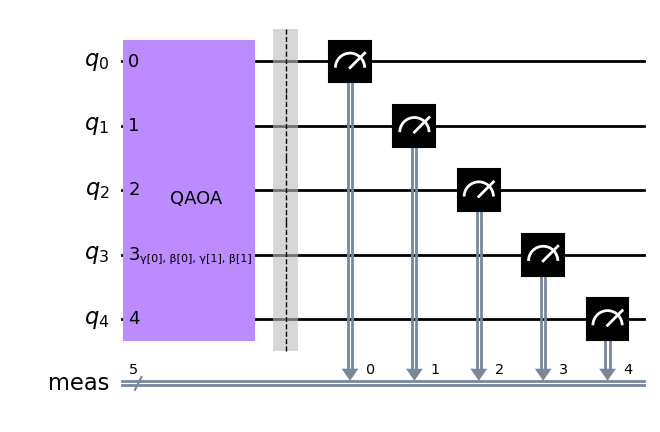

In [5]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_hamiltonian, reps=2)
# reps is the number of QAOA layers

circuit.measure_all()

circuit.draw("mpl", fold=-1, style="clifford")

In [6]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

β[0], β[1]: Mixer angles for each QAOA layer.
γ[0], γ[1]: Cost Hamiltonian angles for each QAOA layer.

## Step 2. Making our circuit executable

As discussed before, our circuit is not possible to run on the hardware today. So we need to transpile (also called optimise) the circuit for todays hardware using Qiskit's Pass Manager.

**What is transpilation?**

Transpilation is the process by which we can rewrite a given circuit into something that can run on the topology of a specific quantum backend, and also reduce noise. 

Qiskit's transpiler pipeline consists of 6 fundamental stages:

#### 1. Init

This usually does very little, unless you want to include your own optimisation. Additionally since downstream steps are only designed for 1 to 2 Qubit gates, this stage translates any gates >2 wubits into 1 or 2 qubit gates.

#### 2. Layout
Quantum circuit's use virtual qubits or logical qubits, so we need to map these one to one to physical qubits on a backend. This is very important to minimise the number of SWAP operations needed, whilst also ensuring the most well-calibrated qubits are used. 

See below. 

In [7]:
ghz.draw("mpl", idle_wires=False)

NameError: name 'ghz' is not defined

Note: you may need to restart the kernel to use updated packages.


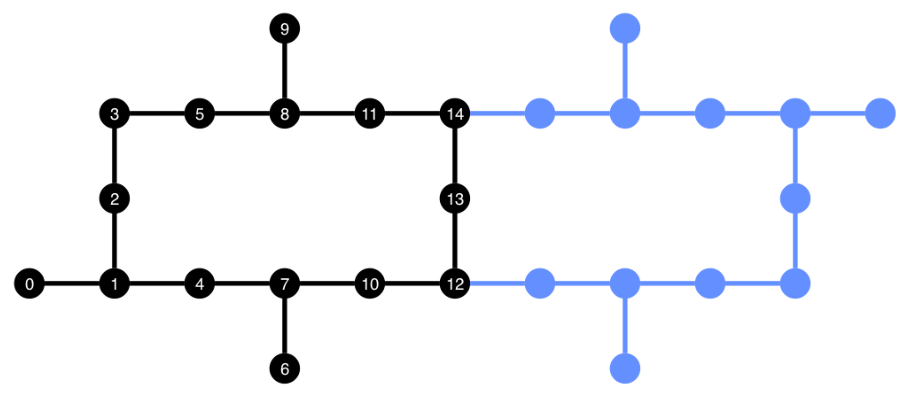

In [ ]:
%pip install Graphviz
from qiskit.visualization import plot_circuit_layout # note Graphviz package and system binary (dot) must be installed
 
# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
transpiled_circ = pass_manager.run(ghz)
plot_circuit_layout(transpiled_circ, fake_backend)

**What are SWAP Operations?**
SWAP gates take two qubits and swap's their states. Therefore, SWAP gates help move qubit states across the circuit since in many quantum architectures like superconducting qubits or quantum dots, useful when qubits can only interact with their immediate neightbours.

#### 3. Routing

So we have logical qubits that have been mapped to physical qubits. Now in a circuit, we may apply a two-qubit gate to any one of the physical qubits. The issue is, is that they are not adjacent, so we use the aforementioned SWAP gates to move this around. Now this happens in conjunction with the above stage. Where the Layout stages selects the hardware qubits to use, and the Routing stage determines the SWAP gates needed to execute the circuit.

It turns out, this is a NP-hard problem, so bloody hard. Qiskit uses a cool sounding algorithm called SabreSwap to find a good solution. However, it is **stochastic**, therefore, each output may be slightly different. In some cases, it's worth running this multiple times and finding the lowest depth result. 


Text(0, 0.5, 'Counts')

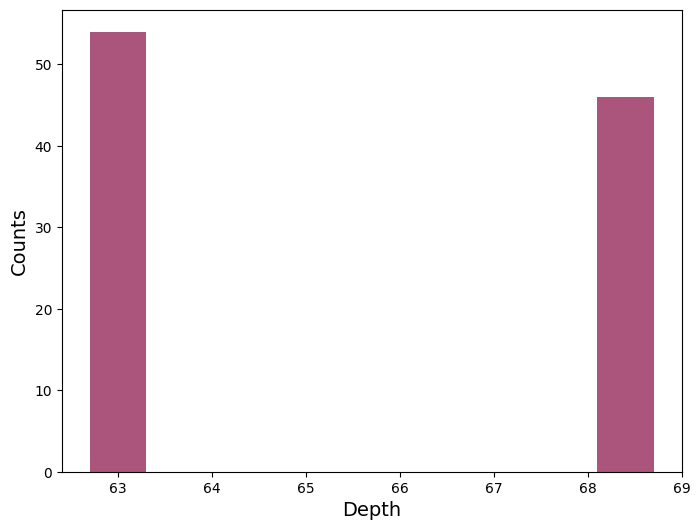

In [ ]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAuckland, FakeWashingtonV2
from qiskit.transpiler import generate_preset_pass_manager
 
fake_backend = FakeAuckland()
 
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
for seed in range(100):
    pass_manager = generate_preset_pass_manager(
        optimization_level=1,
        backend=fake_backend,
        layout_method="trivial",  # Fixed layout mapped in circuit order
        seed_transpiler=seed,  # For reproducible results
    )
    depths.append(pass_manager.run(ghz).depth())
 
plt.figure(figsize=(8, 6))
plt.hist(depths, align="left", color="#AC557C")
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)


#### 4. Translation

When you are desiging your quantum circuit, you have full freedom to choose whatever mystical gate your heart desires:
- Z
- Y
- Z
- H
- CNOT
- Toffoli (CCX)

and non-gate operations such as:
- qubit measurement
- rest instructions
- barrier

however, quantum devices only support a set of native gates. Therefore, this stage converts your circuit to use only the native (basis) gates supported by the target backend.

- If a SWAP gate is not a native gate to the target backend, this requires three CNOT gates
- For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates and a handful of single-qubit gates. 


In [ ]:
print("native gates:" + str(sorted(fake_backend.configuration().basis_gates)))

native gates:['cx', 'id', 'rz', 'sx', 'x']


#### 5. Optimisation

Reduces the circuit’s resource requirements (gate count, depth, error rate) while preserving its logic. Techniques include gate cancellation, merging, commutation, and reordering. The goal is to make the circuit as efficient and robust as possible for execution on noisy hardware.

For optimization_level=1, this stage prepares Optimize1qGatesDecomposition and CXCancellation, which combine chains of single-qubit gates and cancel any back-to-back CNOT gates.

For optimization_level=2, this stage uses the CommutativeCancellation pass instead of CXCancellation, which removes redundant gates by exploiting commutation relations.

For optimization_level=3, this stage prepares the following passes:
Collect2qBlocks
ConsolidateBlocks
UnitarySynthesis
Optimize1qGateDecomposition
CommutativeCancellation

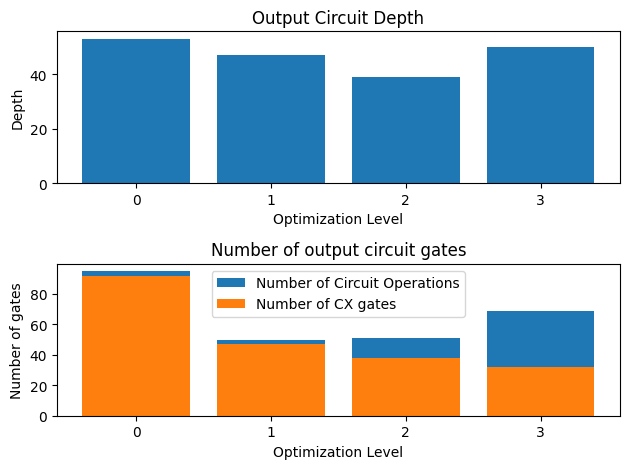

In [ ]:
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=fake_backend,
        seed_transpiler=1234,
    )
    circ = pass_manager.run(ghz)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
 
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

#### 6. Scheduling

This only takes place if called for, and requires passing the scheduling_method argument. In this stage, we explicitly insert delay instructions to accound for the idle time between gate executions. Also allowing you to inspect how long the circuit will be running.


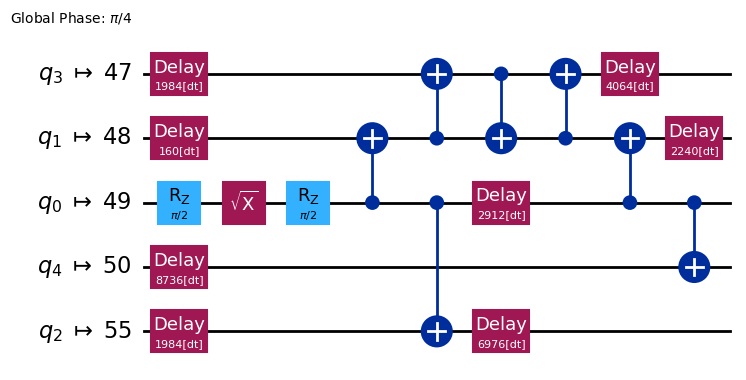

In [ ]:
ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0, range(1, 5))
 
 
# Use fake backend
backend = FakeWashingtonV2()
 
# Run with optimization level 3 and 'asap' scheduling pass
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    scheduling_method="asap",
    seed_transpiler=1234,
)
 
 
circ = pass_manager.run(ghz)
circ.draw(output="mpl", idle_wires=False)

### Back to the Max-Cut Circuit Transpilation

In [ ]:
import sys
sys.path.append('../..')
from qiskit_service import service
from qiskit.transpiler import generate_preset_pass_manager

backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)

print(candidate_circuit.count_ops())

candidate_circuit.draw("mpl", fold=False, idle_wires=False)

management.get:WARNING:2025-10-31 11:43:37,060: Loading default saved account


<IBMBackend('ibm_fez')>


NameError: name 'circuit' is not defined

#### What we have in our transpiled circuit?

<explain> 
OrderedDict({'rz': 72, 'sx': 65, 'cz': 36, 'measure': 5, 'barrier': 1})

## Step 3. Execution

### A. Define the initial parameters




In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

### B. Set up the Session

We have two options for the Runtime primitive that interacts with the backend. We are going to choose the Estimator, since we just want the expectation value of $ H_C $ vs the sampler, that measures the outcome probailities.

There are various "execution modes" to schedule workloads:
- Single-job
- Batch
- Sessions (sequential jobs)

In this case, we will use sessions to allow for faster iterative workloads.



1. Transform Hamiltonian:
isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
Adapts the cost Hamiltonian to match the physical qubit layout of the transpiled circuit.

2. Prepare Input:
pub = (ansatz, isa_hamiltonian, params)
Bundles the circuit (ansatz), the adapted Hamiltonian, and the current parameter values.

3. Run Estimator:
job = estimator.run([pub])
Submits the circuit and Hamiltonian to the Qiskit Runtime Estimator, which calculates the expectation value.

4. Get Result:
results = job.result()[0]
Retrieves the result from the Estimator job.

5. Extract Cost:
cost = results.data.evs
Gets the expectation value (the cost function value for these parameters).

6. Track Values:
objective_func_vals.append(cost)
Stores the cost value for later analysis.

7. Return Cost:
return cost
Returns the cost to the optimizer, which uses it to update parameters.

In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [ ]:
from qiskit_ibm_runtime import Estimator, Session
from scipy.optimize import minimize

objective_func_vals = []  # Global variable

with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator, ## Our function to minimize
        init_params, ## these change at each iteration
        args=(candidate_circuit, cost_hamiltonian, estimator), ## Additional arguments for our function
        method="COBYLA", ## Optimization method
        tol=1e-2, ## Tolerance for termination
        options={"maxiter": 5}
    )
    print(result)

RequestsApiError: '400 Client Error: Bad Request for url: https://quantum.cloud.ibm.com/api/v1/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"d75cbc31-fd8d-4aff-96e8-34f55ce77cfb"}\n'

** Turns out I'm too poor to run a session on IBM, so having to switch to job mode with limited attempts ** 

In [ ]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = []  # Global variable

def cost_func_estimator_single(params, ansatz, hamiltonian, backend):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    options = EstimatorOptions()
    options.default_shots = 1000
    options.dynamical_decoupling.enable = True
    options.dynamical_decoupling.sequence_type = "XY4"
    options.twirling.enable_gates = True
    options.twirling.num_randomizations = "auto"
    estimator = Estimator(backend, options=options)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator_single,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, backend),
    method="COBYLA",
    tol=1e-2,
    options={"maxiter": 15},
)
print(result)

 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -1.8386508159365995
       x: [ 1.614e+00  1.217e+00  2.824e+00  3.653e+00]
    nfev: 15
   maxcv: 0.0


 Result:
 
 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -1.8386508159365995
       x: [ 1.614e+00  1.217e+00  2.824e+00  3.653e+00]
    nfev: 15
   maxcv: 0.0

From this returned object, we get the:
- message = why the optimiser stopped
- Success = Whether a solution / convergence was found
- status = exit code (3 equals maximum number of function evaluations reached)
- fun = The value of the function (cost) at the final parameter
- x = The parameters that found the best result
- nfev = The number of times the function ran
- maxcv = Maximum constraint violation, so 0 means all contraints (if any) were satisfied

**What is pauli twirling?**

So we know that Pauli is operations on Qubits:
- I (identity)
- X (bit flip 0 -> 1)
- Z (phase flip)
- Y (bit + phase flip)

If we put two in order, they cancel out. This is important, so if we have a noisy operation (e.g. a CNOT), we can place an operation on either side of a gate like CNOT, so that in reality the outcome is the same from a quantum circuit standpoint, however, the noise is different. By doing this randomly, we can average the results over these randomisations. ... Okay, it might be easiest to show you below!
Both these circuits are the same. 

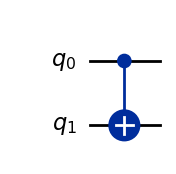

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.cx(0, 1)       # CNOT gate
qc.draw('mpl')

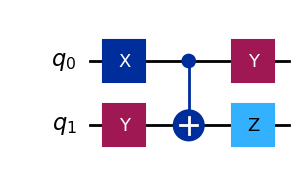

In [ ]:
# Example: Pauli-X twirling around a CNOT gate

qc = QuantumCircuit(2)
qc.x(0)           # Pauli-X on control qubit
qc.y(1)           # Pauli-Y on target qubit
qc.cx(0, 1)       # CNOT gate
qc.y(0)           # Pauli-Y on control qubit (again)
qc.z(1)           # Pauli-Z on target qubit (again)
qc.draw('mpl')

**What is COBYLA?**

Constrained Optimisation By Linear Approximation has a few different key features:
- It's **derivative free** e.g. does not require calculation of the gradients. This is important as results from the cost function are noisy, therefore estimating gradients is difficult.
- It's **constrained** but note, we don't add constraints in our example. So I guess it's unconstrained???
- It's a **linear approximation** so COBYLA builds a local linear approximation at each iteration, using these to adjust the parameters for the next step

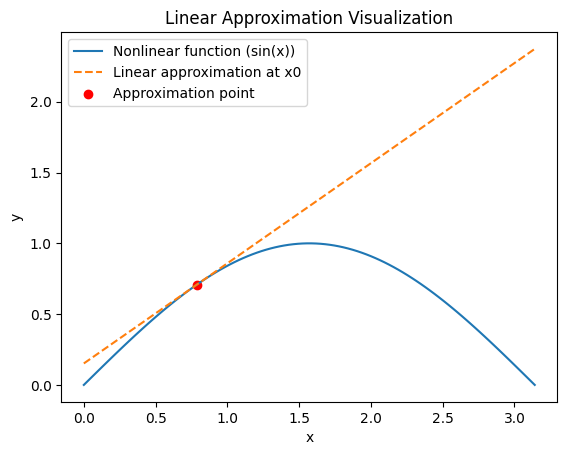

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Nonlinear function
def f(x):
    return np.sin(x)

# Point to approximate around
x0 = np.pi / 4
y0 = f(x0)

# Linear approximation (tangent line)
slope = np.cos(x0)
def linear_approx(x):
    return y0 + slope * (x - x0)

x = np.linspace(0, np.pi, 100)
plt.plot(x, f(x), label='Nonlinear function (sin(x))')
plt.plot(x, linear_approx(x), '--', label='Linear approximation at x0')
plt.scatter([x0], [y0], color='red', label='Approximation point')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Approximation Visualization')
plt.show()

## Step 4. So finalllyyyy, what's the outcome?





### Visualising the Result

In [ ]:
print(objective_func_vals)

[array(-0.08091154), array(-0.07206798), array(-0.00766021), array(0.13332994), array(0.21077233), array(0.13076025), array(-0.41763292), array(0.30729629), array(2.25570672), array(-0.41130587), array(-0.38203956), array(-0.93464736), array(-1.48509795), array(-1.79599195), array(-1.83865082)]


[array(-0.08091154), array(-0.07206798), array(-0.00766021), array(0.13332994), array(0.21077233), array(0.13076025), array(-0.41763292), array(0.30729629), array(2.25570672), array(-0.41130587), array(-0.38203956), array(-0.93464736), array(-1.48509795), array(-1.79599195), array(-1.83865082)]

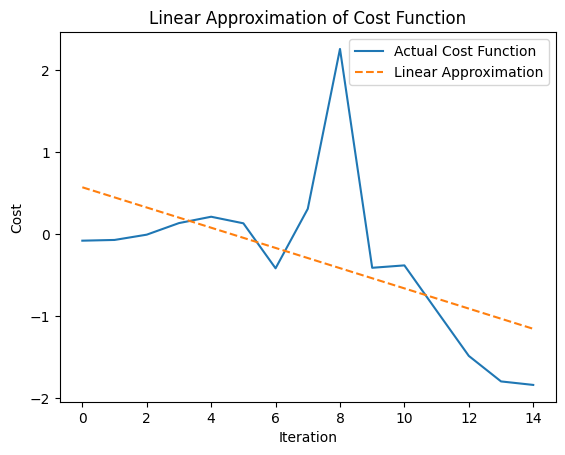

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated iteration numbers
iterations = np.arange(len(objective_func_vals))
costs = np.array(objective_func_vals)

# Linear fit (approximation)
fit = np.polyfit(iterations, costs, 1)
linear_approx = np.polyval(fit, iterations)

plt.plot(iterations, costs, label='Actual Cost Function')
plt.plot(iterations, linear_approx, '--', label='Linear Approximation')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Linear Approximation of Cost Function')
plt.legend()
plt.show()

We can see here how the cost minimises over time. That's cool right. It's a shame I couldn't afford more than 15 ierations. But hey ho!

Now we have the "optimal" parameters for the circuit. These values were found by the optimizer to (approximately) minimize your cost function for the Max-Cut problem. Assigning them to the circuit fixes the QAOA circuit to the best solution found. We have turned our variational algorithm into a fixed circuit. We need to run these through a sampler to obtain a probability distribution of bitstring measurements which correspond to the optimal cut of the graph.


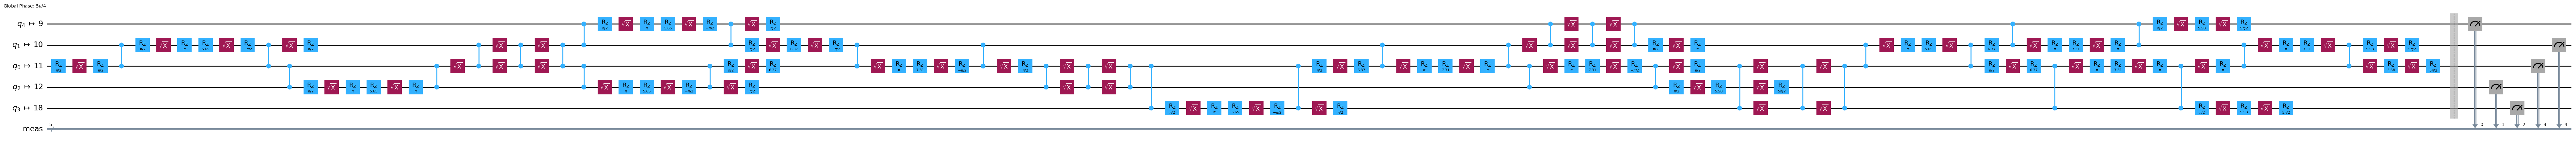

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters([ 1.614e+00,  1.217e+00,  2.824e+00,  3.653e+00])
optimized_circuit.draw("mpl", fold=False, idle_wires=False)


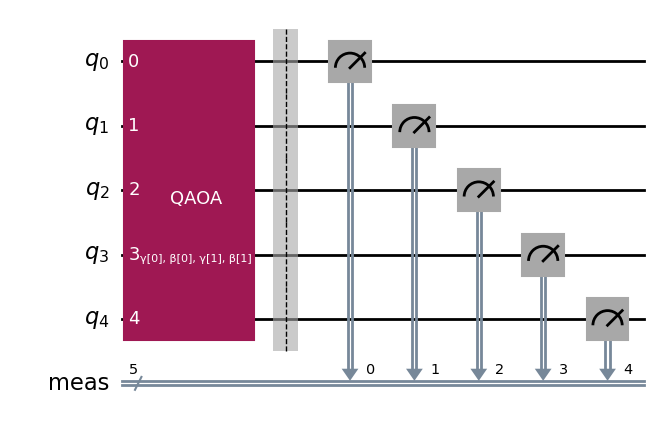

In [ ]:
# vs our original circuit with initial parameters
circuit.draw("mpl", fold=False, idle_wires=False)

# Finding bitstrings

In [19]:
from qiskit_ibm_runtime import SamplerOptions, Sampler

sampler_options = SamplerOptions()
sampler_options.default_shots = 1000
sampler_options.dynamical_decoupling.enable = True
sampler_options.dynamical_decoupling.sequence_type = "XY4"
sampler_options.twirling.enable_gates = True
sampler_options.twirling.num_randomizations = "auto"

pub = (optimized_circuit, )

sampler = Sampler(backend, options=sampler_options)
job = sampler.run([pub], shots=1000)
print(job.job_id())

d41g8ech4j8s73egh8r0


In [4]:
retrieved_job = service.job("d41g8ech4j8s73egh8r0")
result = retrieved_job.result()
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1000, num_bits=5>)), metadata={'circuit_metadata': {}, 'num_randomizations': 16})], metadata={'execution': {'execution_spans': ExecutionSpans([TwirledSliceSpanV2(<start='2025-10-30 08:38:18', stop='2025-10-30 08:38:19', size=1024>)])}, 'version': 2})


In [6]:
counts_int = retrieved_job.result()[0].data.meas.get_int_counts()
counts_bin = retrieved_job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{20: 0.081, 9: 0.087, 27: 0.023, 26: 0.043, 24: 0.015, 11: 0.098, 3: 0.024, 23: 0.015, 16: 0.013, 10: 0.042, 14: 0.033, 21: 0.044, 18: 0.05, 5: 0.047, 22: 0.068, 8: 0.011, 17: 0.024, 13: 0.059, 30: 0.022, 1: 0.028, 28: 0.015, 12: 0.025, 6: 0.023, 4: 0.023, 25: 0.02, 2: 0.011, 19: 0.017, 29: 0.011, 7: 0.01, 0: 0.004, 15: 0.01, 31: 0.004}


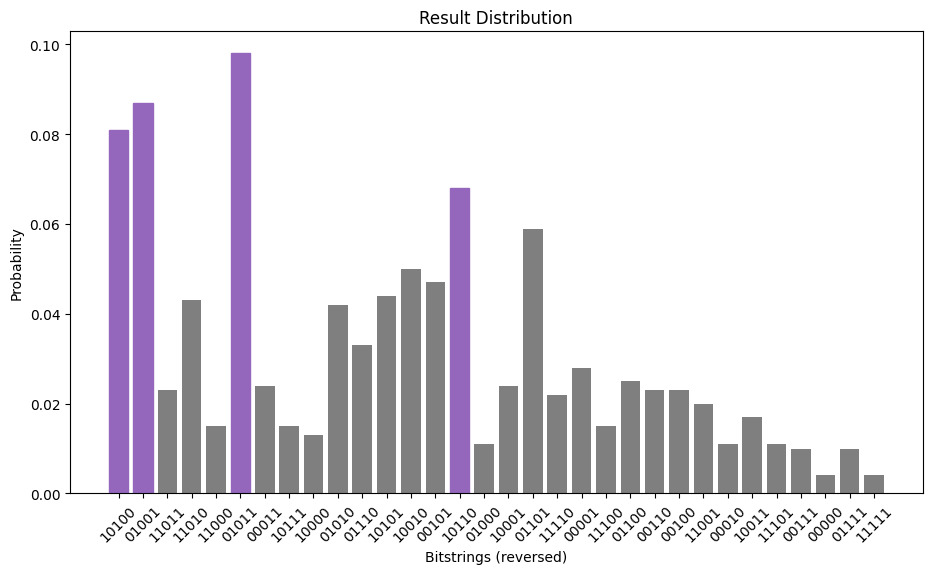

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed) as the bitstrings are returned in little-endian format")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

From this, we can see that the bitstring 11010 is the most likely, and therefore the optimal Max-Cut partition found by the quantum algorithm assigns nodes 0, 1, and 3 to one set (value 1), and nodes 2 and 4 to the other set (value 0). This partition maximizes the number of edges cut between the two groups, according to the QAOA solution.

In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse() # we reverse as the bitstrings are returned in little-endian format
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0]


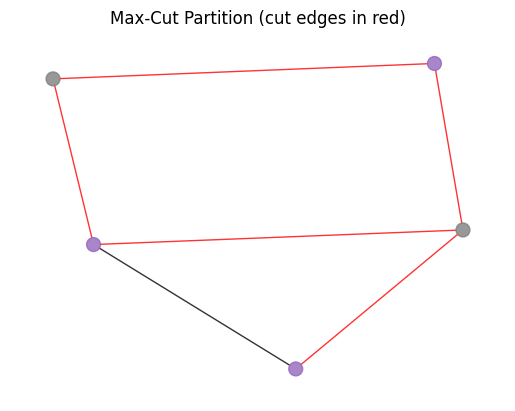

In [21]:
def plot_result_with_cuts(G, x):
    # Color nodes by partition
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    # Highlight cut edges in red, others in black
    edge_colors = [
        "red" if x[u] != x[v] else "black"
        for u, v in G.edge_list()
    ]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=100, alpha=0.8, pos=pos, edge_color=edge_colors
    )
    plt.title("Max-Cut Partition (cut edges in red)")
    plt.show()

# Usage:
plot_result_with_cuts(graph, most_likely_bitstring)

### Wrapping Up


There we have it, we have found a "potentially" optimal solution to the max-cut problem. With a cut of 5.